In [1]:
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve, roc_auc_score,auc
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize,StandardScaler
from sklearn.naive_bayes import GaussianNB
from skopt import BayesSearchCV
import numpy as np

In [2]:
data = pd.read_csv('./dataset/kdd_cup99_10_percent.csv')
data_smote = pd.read_csv('./dataset/kdd_cup99_10_percent.csv')
labels = ['dos','normal','prode','r2l','u2r']

In [6]:
Y_train = data[['attack_type_digit']]
X_train = data.drop(['label','label_digit','attack_type','attack_type_digit','service'], axis=1)

Y_test = data_smote[['attack_type_digit']]
X_test = data_smote.drop(['label','label_digit','attack_type','attack_type_digit','service'], axis=1)

In [7]:

# 使用 MinMaxScaler 进行归一化
scaler = StandardScaler()  # 或者 StandardScaler()，根据需求选择
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 打印归一化后的数据范围
print("Scaled X_train range:", X_train_scaled.min(), X_train_scaled.max())
print("Scaled X_test range:", X_test_scaled.min(), X_test_scaled.max())

# 检查训练和测试数据大小是否一致
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

Scaled X_train range: -3.5905420820176315 701.6399673493991
Scaled X_test range: -3.5905420820176315 701.6399673493991
X_train_scaled shape: (494021, 30)
X_test_scaled shape: (494021, 30)


In [8]:
# 二元化标签
Y_train_binarized = label_binarize(Y_train, classes=range(len(labels)))
Y_test_binarized = label_binarize(Y_test, classes=range(len(labels)))


In [9]:
# 定义超参数搜索空间
search_spaces = {
    'n_estimators': (50, 500),  # 决策树的数量
    'max_depth': (5, 50),       # 决策树的最大深度
    'max_features': (0.1, 1.0, 'uniform'),  # 每棵树使用特征的比例
    'min_samples_split': (2, 10),  # 内部节点再划分所需的最小样本数
    'min_samples_leaf': (1, 10),   # 叶子节点所需的最小样本数
}

# 初始化随机森林分类器
rnd_clf = RandomForestClassifier(random_state=42)

# 贝叶斯优化搜索
bayes_search = BayesSearchCV(
    estimator=rnd_clf,
    search_spaces=search_spaces,
    n_iter=5,  # 优化迭代次数
    scoring='accuracy',  # 优化目标：准确率
    cv=StratifiedKFold(n_splits=3),  # 使用 3 折交叉验证
    n_jobs=-1,  # 使用所有可用 CPU 核心
    random_state=42
)

# 执行搜索
print("Starting Bayesian Optimization...")
bayes_search.fit(X_train, Y_train.values.ravel())

# 最优参数和结果
print("Best Parameters:", bayes_search.best_params_)
print("Best Accuracy:", bayes_search.best_score_)

# 使用最优参数的模型进行测试
best_model = bayes_search.best_estimator_
y_pred_rf = best_model.predict(X_test)
y_pred_proba_rf = best_model.predict_proba(X_test)

Starting Bayesian Optimization...
Best Parameters: OrderedDict([('max_depth', 25), ('max_features', 0.9268502695024393), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 135)])
Best Accuracy: 0.9906886250327033


In [10]:
# 定义超参数搜索空间
search_spaces = {
    'var_smoothing': (1e-12, 1e-8, 'log-uniform')  # 高斯分布的平滑参数
}

# 初始化朴素贝叶斯分类器
nb_clf = GaussianNB()

# 贝叶斯优化搜索
bayes_search = BayesSearchCV(
    estimator=nb_clf,
    search_spaces=search_spaces,
    n_iter=5,  # 优化迭代次数
    scoring='accuracy',  # 优化目标：准确率
    cv=StratifiedKFold(n_splits=3),  # 使用 3 折交叉验证
    n_jobs=-1,  # 使用所有可用 CPU 核心
    random_state=42
)

# 执行搜索
print("Starting Bayesian Optimization for Naive Bayes...")
bayes_search.fit(X_train, Y_train.values.ravel())

# 最优参数和结果
print("Best Parameters for Naive Bayes:", bayes_search.best_params_)
print("Best Accuracy for Naive Bayes:", bayes_search.best_score_)

# 使用最优参数的模型进行测试
best_model_nb = bayes_search.best_estimator_
y_pred_nb = best_model_nb.predict(X_test)
y_pred_proba_nb = best_model_nb.predict_proba(X_test)

Starting Bayesian Optimization for Naive Bayes...
Best Parameters for Naive Bayes: OrderedDict([('var_smoothing', 2.236420282054271e-09)])
Best Accuracy for Naive Bayes: 0.8736467887391881


In [11]:
# 3.训练决策树模型
model = DecisionTreeClassifier(criterion='gini', random_state=42)
# 定义超参数搜索空间
param_grid = {
 'max_depth': [5, 10, 15, 20, None], # 树的最大深度
 'min_samples_split': [2, 5, 10], # 划分的最小样本数
 'min_samples_leaf': [1, 2, 4], # 叶子节点的最小样本数
 'ccp_alpha': [0.0, 0.01, 0.1, 0.5] # 剪枝参数
}
# 使用网格搜索进行超参数调优
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

# 输出最佳超参数
print("Best parameters found: ", grid_search.best_params_)

# 使用最佳参数重新训练模型
best_model = grid_search.best_estimator_
best_model.fit(X_train, Y_train)

# 在测试集上进行预测
y_pred_dt = best_model.predict(X_test)
y_pred_proba_dt = best_model.predict_proba(X_test)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters found:  {'ccp_alpha': 0.0, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [12]:
#打印分类报告（随机森林和决策树和朴素贝叶斯）
print("=== Random Forest Classification Report ===")
print(classification_report(Y_test, y_pred_rf, target_names=labels))

print("\n=== Decision Tree Classification Report ===")
print(classification_report(Y_test, y_pred_dt, target_names=labels))

print("\n=== Gaussian Byes Classification Report ===")
print(classification_report(Y_test, y_pred_nb, target_names=labels))

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00    391458
      normal       1.00      1.00      1.00     97278
       prode       1.00      0.99      1.00      4107
         r2l       1.00      0.97      0.99      1126
         u2r       0.96      0.85      0.90        52

    accuracy                           1.00    494021
   macro avg       0.99      0.96      0.98    494021
weighted avg       1.00      1.00      1.00    494021


=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00    391458
      normal       1.00      1.00      1.00     97278
       prode       1.00      0.98      0.99      4107
         r2l       1.00      0.94      0.97      1126
         u2r       1.00      0.71      0.83        52

    accuracy                           1.00    494021
   macro avg       1.00      0.93      0.9

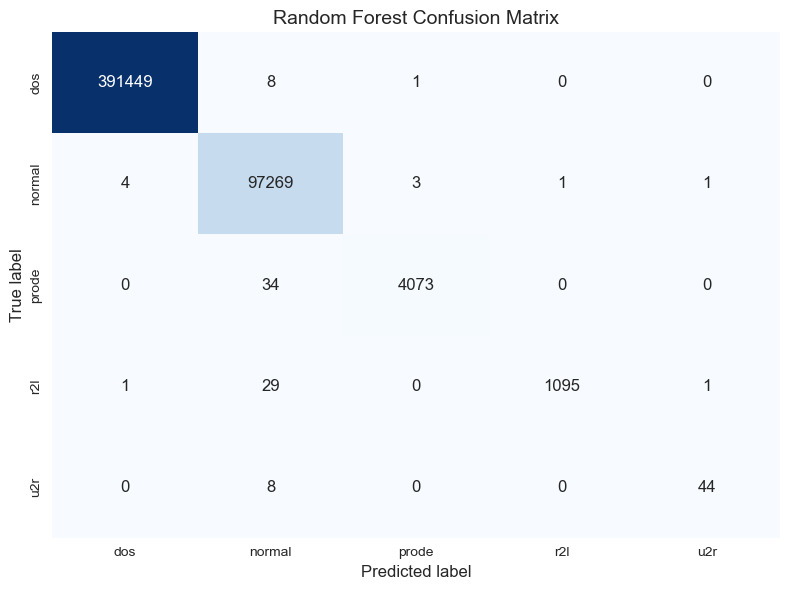

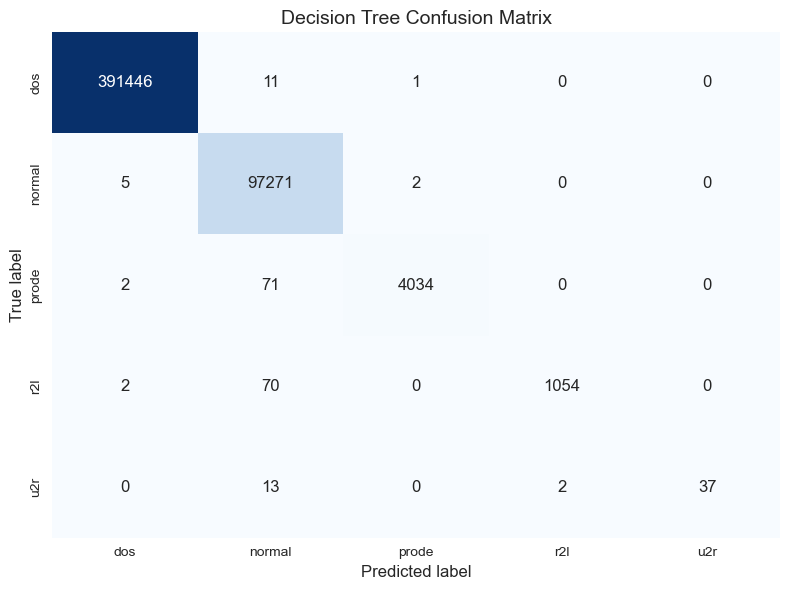

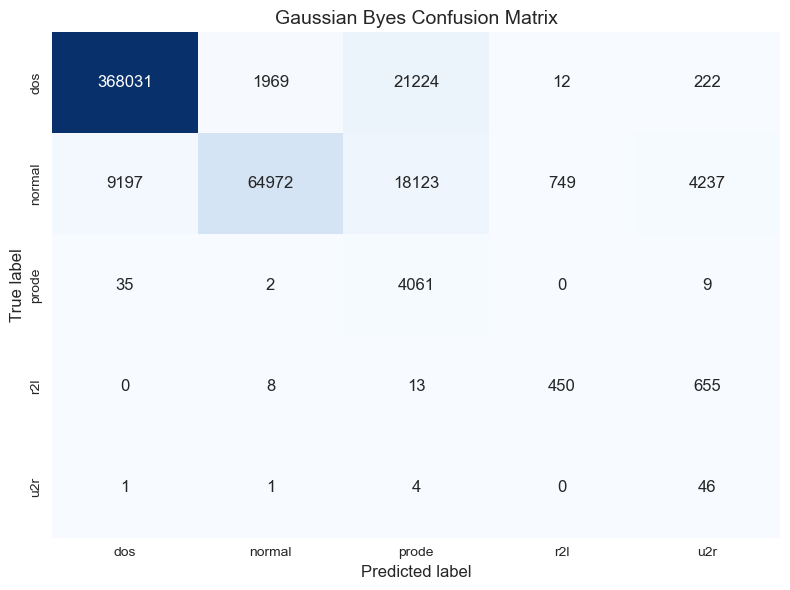

=== Plotting ROC Curves ===


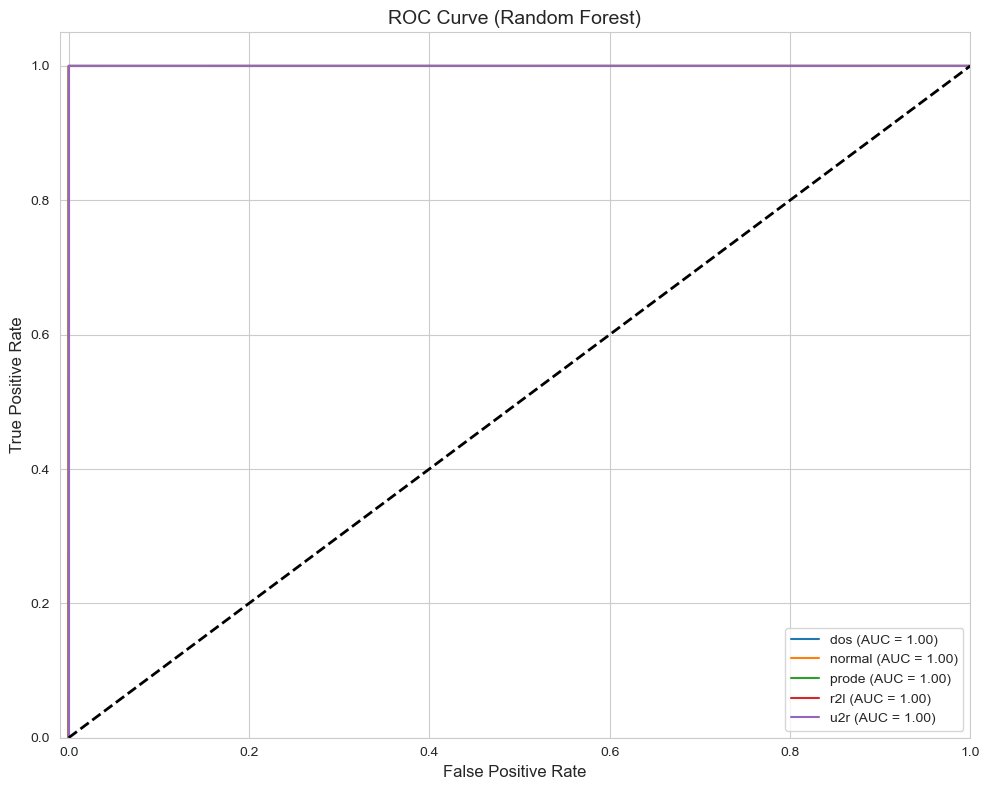

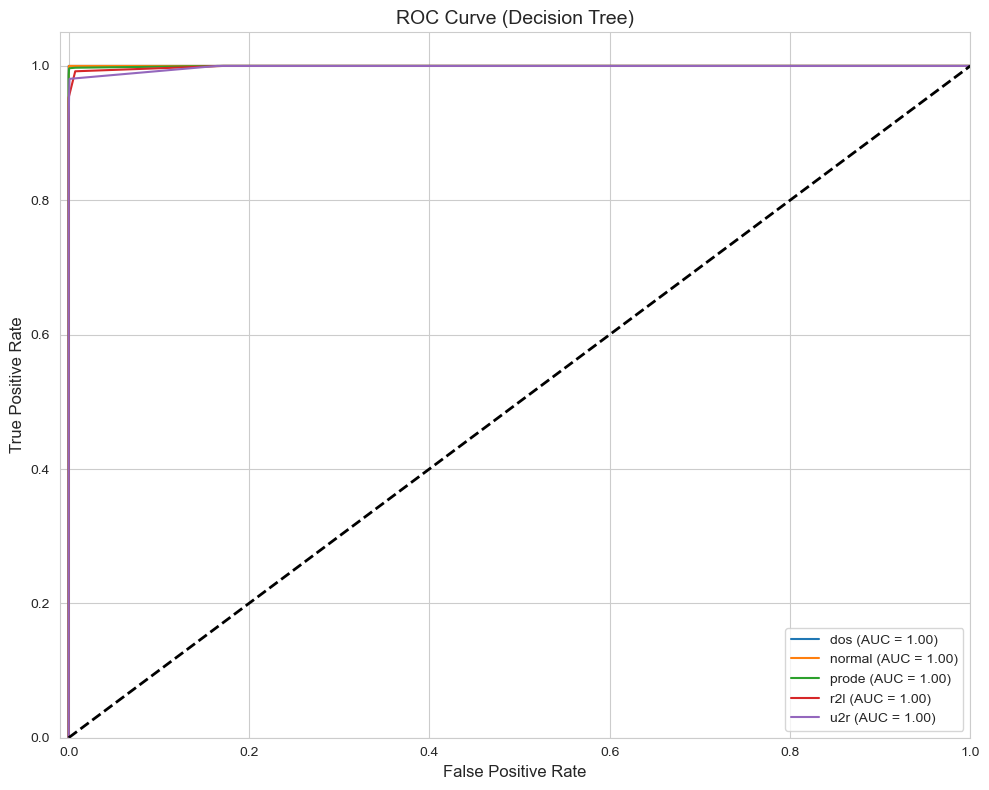

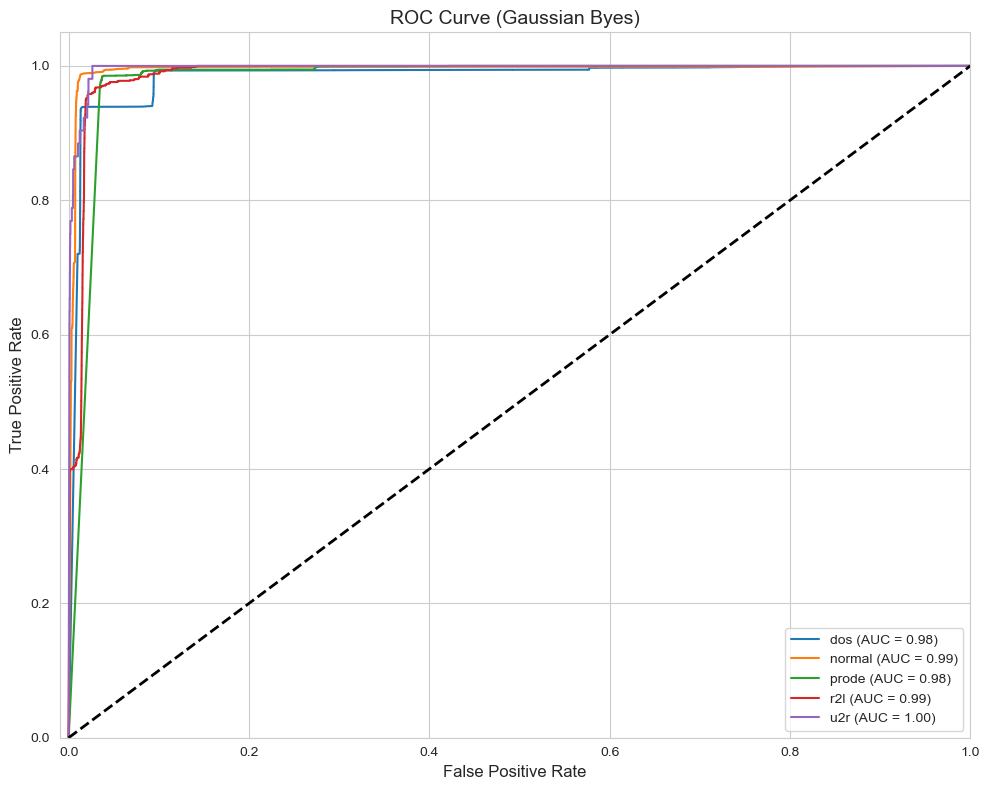

In [13]:
# 4. 混淆矩阵（随机森林和决策树）
def plot_confusion_matrix(cm, model_name, labels):
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 12})
    plt.title(f'{model_name} Confusion Matrix', fontsize=14)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.show()

# 混淆矩阵可视化
cm_rf = confusion_matrix(Y_test, y_pred_rf)
cm_dt = confusion_matrix(Y_test, y_pred_dt)
cm_nb = confusion_matrix(Y_test, y_pred_nb)
plot_confusion_matrix(cm_rf, "Random Forest", labels)
plot_confusion_matrix(cm_dt, "Decision Tree", labels)
plot_confusion_matrix(cm_nb, "Gaussian Byes", labels)

# 5. 绘制ROC曲线函数
def plot_roc_curve(Y_test_binarized, y_pred_proba, labels, model_name):
    n_classes = len(labels)
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 绘制每个类别的ROC曲线
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

    # 绘制对角线
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.title(f"ROC Curve ({model_name})", fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    plt.show()

# 绘制ROC曲线
print("=== Plotting ROC Curves ===")
plot_roc_curve(Y_test_binarized, y_pred_proba_rf, labels, "Random Forest")
plot_roc_curve(Y_test_binarized, y_pred_proba_dt, labels, "Decision Tree")
plot_roc_curve(Y_test_binarized, y_pred_proba_nb, labels, "Gaussian Byes")

       Classifier   Class  Precision    Recall  F1-Score
0   Random Forest     dos   0.999987  0.999977  0.999982
1   Random Forest  normal   0.999188  0.999907  0.999548
2   Random Forest   prode   0.999019  0.991721  0.995357
3   Random Forest     r2l   0.999088  0.972469  0.985599
4   Random Forest     u2r   0.956522  0.846154  0.897959
5   Decision Tree     dos   0.999977  0.999969  0.999973
6   Decision Tree  normal   0.998307  0.999928  0.999117
7   Decision Tree   prode   0.999257  0.982225  0.990668
8   Decision Tree     r2l   0.998106  0.936057  0.966086
9   Decision Tree     u2r   1.000000  0.711538  0.831461
10    Naive Bayes     dos   0.975526  0.940154  0.957514
11    Naive Bayes  normal   0.970427  0.667900  0.791232
12    Naive Bayes   prode   0.093518  0.988800  0.170874
13    Naive Bayes     r2l   0.371594  0.399645  0.385109
14    Naive Bayes     u2r   0.008899  0.884615  0.017621


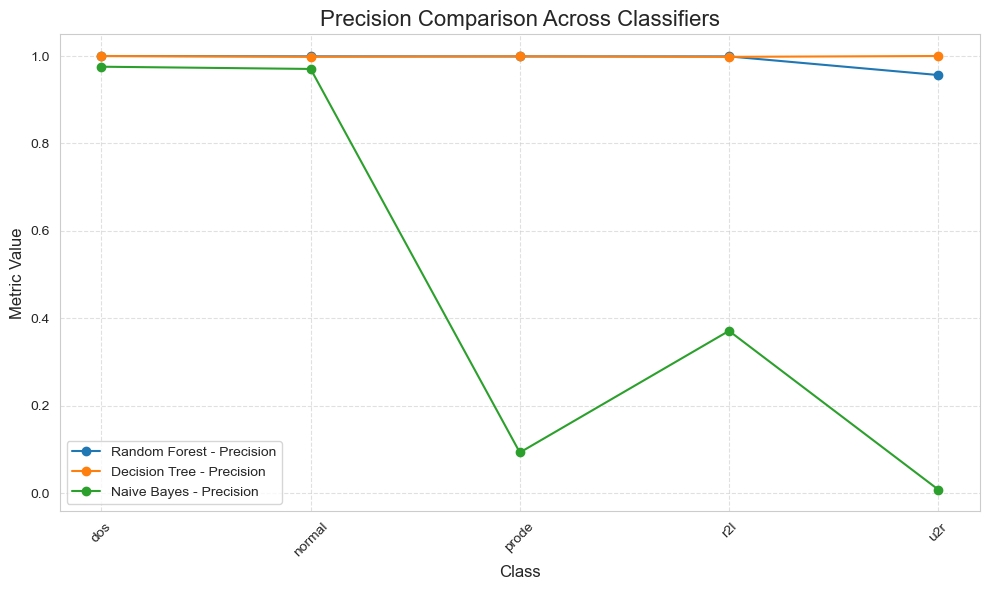

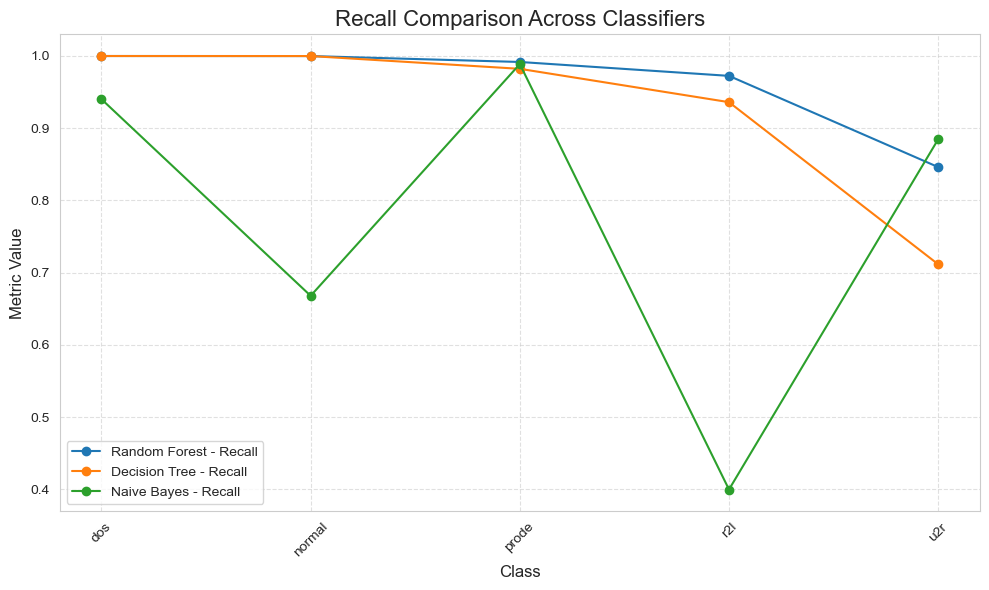

In [14]:
# 使用 classification_report(y_true, y_pred, output_dict=True) 生成
reports = {
    "Random Forest": classification_report(Y_test, y_pred_rf, target_names=labels, output_dict=True),
    "Decision Tree": classification_report(Y_test, y_pred_dt, target_names=labels, output_dict=True),
    "Naive Bayes": classification_report(Y_test, y_pred_nb, target_names=labels, output_dict=True),
}

# 定义分类器名称和性能指标
classifiers = ["Random Forest", "Decision Tree", "Naive Bayes"]
metrics = ["Precision", "Recall", "F1-Score"]

# 构建 metrics_df
df_list = []
for clf_name, report in reports.items():
    for label in labels:
        precision = report[label].get('precision', 0)
        recall = report[label].get('recall', 0)
        f1_score = report[label].get('f1-score', 0)
        df_list.append({
            "Classifier": clf_name,
            "Class": label,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score
        })

metrics_df = pd.DataFrame(df_list)
print(metrics_df)

# 绘制 Precision 曲线
plt.figure(figsize=(10, 6))
for clf_name in classifiers:
    precision_values = metrics_df[metrics_df["Classifier"] == clf_name]["Precision"].values
    if len(precision_values) > 0:
        plt.plot(labels, precision_values, marker='o', label=f"{clf_name} - Precision")

plt.title("Precision Comparison Across Classifiers", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 绘制 Recall 曲线
plt.figure(figsize=(10, 6))
for clf_name in classifiers:
    recall_values = metrics_df[metrics_df["Classifier"] == clf_name]["Recall"].values
    if len(recall_values) > 0:
        plt.plot(labels, recall_values, marker='o', label=f"{clf_name} - Recall")

plt.title("Recall Comparison Across Classifiers", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()